## Introduction

This notebook contains the source codes for the final project. The project is about predicting the car price in Turkey using the data from [sahibinden.com](https://www.sahibinden.com/). For detailed information about the project, please refer to the [project proposal](https://github.com/BerkkanB/MAT-381E-FINAL-PROJECT/blob/main/Final-Project-Proposal.ipynb).

Importing the necessary libraries:
- BeautifullSoup is used for web scraping
- numpy and pandas are used for data manipulation
- matplotlib is used for data visualization
- sklearn is used for machine learning algorithms
- ipywidgets is used for interactive widgets


In [1]:
from bs4 import BeautifulSoup
import requests
from slugify import slugify
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


## Web Scraping and Data Collection

Since sahibinden.com does not make its data available via an API or an excel file, we had to pull the data directly from the website. For this purpose, we used the BeautifulSoup library.


In [2]:
BASE_URL = "https://www.sahibinden.com/"
HOME_PAGE = "https://www.sahibinden.com/otomobil/" 

`get_html` function takes the url of the page as an input and call the url with appropriate headers. Then it returns the html content of the page.

In [3]:
def get_html(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0","accept": "text/html"})
    return response.content

base_page = get_html(HOME_PAGE)
soup = BeautifulSoup(base_page, "html.parser")


Since there are lots of car brands in sahibinden, we decided to scrape the data according to user input. For this purpose, we parsed the base html page of sahibinden and extracted the all car brands. Then we asked the user to choose a car brand from the list. After the user input, we scraped the data of the chosen car brand.

To get the brand names we looked for html source and found that the brand names are in the `li` tag with class name `cl2`. Then we parsed the html and extracted the brand names.

In [4]:
brands = soup.find_all("li", {"class": "cl2"})

Since they use slug for the urls, we had to convert the brand names to slugs. For this purpose, we used the `slugify` function from the `slugify` library.

In [5]:
def clear_brand_names(data):
    dataList = []
    for tag in data:
        brand = tag.text.strip().split("(")[0].strip() 
        brand = slugify(brand)

        dataList.append(brand)
    return dataList

In [6]:
brandList = clear_brand_names(brands)
brandList

['acura',
 'aion',
 'alfa-romeo',
 'anadol',
 'aston-martin',
 'audi',
 'bentley',
 'bmw',
 'buick',
 'cadillac',
 'chery',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'dodge',
 'ds-automobiles',
 'ferrari',
 'fiat',
 'fisker',
 'ford',
 'geely',
 'honda',
 'hyundai',
 'ikco',
 'infiniti',
 'jaguar',
 'kia',
 'lada',
 'lamborghini',
 'lancia',
 'leapmotor',
 'lexus',
 'lincoln',
 'lotus',
 'marcos',
 'maserati',
 'mazda',
 'mclaren',
 'mercedes-benz',
 'mercury',
 'mg',
 'mini',
 'mitsubishi',
 'moskwitsch',
 'nissan',
 'opel',
 'peugeot',
 'plymouth',
 'polestar',
 'pontiac',
 'porsche',
 'proton',
 'renault',
 'rks',
 'rolls-royce',
 'rover',
 'saab',
 'saturn',
 'seat',
 'skoda',
 'smart',
 'subaru',
 'suzuki',
 'tata',
 'tesla',
 'tofas',
 'toyota',
 'volkswagen',
 'volvo',
 'xev']

Since we get the all brand names now we can take the user input. For this purpose, we used the `ipywidgets` library. We created a dropdown widget and passed the brand names to it. Then we displayed the widget and waited for the user input.

In [7]:
chosenBrand = widgets.Dropdown(
    options=brandList,
    description='Brand:',
    disabled=False
)

chosenBrand

Dropdown(description='Brand:', options=('acura', 'aion', 'alfa-romeo', 'anadol', 'aston-martin', 'audi', 'bent…

In [8]:
MODELS_URL = BASE_URL + chosenBrand.value
MODELS_URL

'https://www.sahibinden.com/seat'

Now we have the brand name, we can scrape the data of the brand. For this purpose, we used the `get_html` function to get the html content of the first page of the brand. Then we parsed the html and extracted the car models. We found that the car models are in the `li` tag with class name `cl3`. Then we parsed the html and extracted the car models.

In [9]:
modelsPage = get_html(MODELS_URL)


models = BeautifulSoup(modelsPage, "html.parser")
models = models.find_all("li", {"class": "cl3"})
models = clear_brand_names(models)
models = np.unique(models)

In [10]:
chosenModel = widgets.Dropdown(
    options=models,
    description='Number:',
    disabled=False,
)
chosenModel

Dropdown(description='Number:', options=('alhambra', 'altea', 'arosa', 'cordoba', 'exeo', 'ibiza', 'leon', 'ma…

Since we get car brand and model names, we can write a function to parse sahibinden datatable and extract the data. For this purpose, we used the `get_html` function to get the html content of the first page of the brand. Then itearted over the pages and extracted the data using the pandas `read_html` function.

In [11]:
def clean_sahibinden_table(table):
    usefulContentDF = table.dropna(axis=0, how="all")
    usefulContentDF = usefulContentDF[["Yıl", "KM", "Fiyat","Model"]]
    usefulContentDF['KM'] = (usefulContentDF['KM']*1000).astype(int)
    usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(" TL", "")
    usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)
    return usefulContentDF

In [13]:
df = pd.DataFrame(columns=["Yıl", "KM", "Fiyat","Model"])

for offset in range(0, 700, 50):
    print(offset)
    QUERY_PARAM = "?pagingOffset={}&pagingSize=50&sorting=date_desc".format(offset)
    QUERY_URL = MODELS_URL + "-" + chosenModel.value + QUERY_PARAM

    content = get_html(QUERY_URL)
    content = BeautifulSoup(content, "html.parser")
    content = content.find("table", {"id": "searchResultsTable"})
    contentDF = pd.read_html(str(content))[0]
    contentDF = clean_sahibinden_table(contentDF)
    df = df.append(contentDF, ignore_index=True)
    
df



0


/var/folders/6t/_5r4qrqj4v9fpq6q5xhtnq4h0000gn/T/ipykernel_14431/3113079336.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  usefulContentDF['Fiyat'] = usefulContentDF['Fiyat'].str.replace(".", "").astype(int)


50
100
150
200
250
300
350
400
450
500
550
600
650


,Yıl,KM,Fiyat,Model
0,2017.0,90000,750000,1.4 EcoTSI FR
1,2014.0,88000,352000,1.4 TSI FR
2,2017.0,123000,670000,1.4 TSI FR
3,2012.0,217000,265000,1.2 TSI Style
4,2017.0,83000,700000,1.6 TDI Style
...,...,...,...,...
703,2019.0,46000,647000,1.6 TDI Style
704,2016.0,97000,669000,1.4 EcoTSI FR
705,2017.0,99000,682000,1.4 EcoTSI FR
706,2008.0,265000,238750,1.6 Stylance


In [ ]:
df

In [14]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['Model']]).toarray(), columns=enc.get_feature_names(['Model']))

/Applications/anaconda3/envs/390/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
final_df = df.join(enc_df)
final_df

,Yıl,KM,Fiyat,Model,Model_1.0 EcoTSI Ecomotive Style,Model_1.0 EcoTSI Style Visio,Model_1.0 TSI Style,Model_1.0 eTSI Style Plus,Model_1.2 TSI Style,Model_1.4 EcoTSI FR,...,Model_1.6 TDI Style,Model_1.6 TDI X-Perience,Model_1.6 TDI Xcellence,Model_1.9 TDI Signo,Model_1.9 TDI Sport,Model_1.9 TDI Style,Model_2.0 TDI CR FR,Model_2.0 TDI Stylance,Model_2.0 TFSI Cupra,Model_2.0 TSI Cupra
0,2017.0,90000,750000,1.4 EcoTSI FR,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014.0,88000,352000,1.4 TSI FR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017.0,123000,670000,1.4 TSI FR,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012.0,217000,265000,1.2 TSI Style,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017.0,83000,700000,1.6 TDI Style,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,2019.0,46000,647000,1.6 TDI Style,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
704,2016.0,97000,669000,1.4 EcoTSI FR,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
705,2017.0,99000,682000,1.4 EcoTSI FR,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
706,2008.0,265000,238750,1.6 Stylance,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
def build_model(X_train, y_train,model):
    if model == "linear":
        model = LinearRegression()
    if model == "svm":
        model = SVR(gamma='scale', C=100000.0, epsilon=0.2)
    if model == "randomforest":
        model = RandomForestRegressor()
    model.fit(X_train, y_train)

    return model

In [17]:
X = final_df.drop(["Fiyat","Model"], axis=1)
y = final_df["Fiyat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
linear_model = build_model(X_train, y_train, "linear")

linear_model.score(X_test, y_test)

0.8987132260525029

In [19]:
y_pred = linear_model.predict(X_test)

In [20]:
def plot_prediction(y_test, y_pred):
    plt.figure(figsize=(12, 7))
    plt.scatter(y_pred, y_test, alpha=0.4)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Predicted vs Actual")
    maxValue = max(y_test.max(), y_pred.max())
    minValue = min(y_test.min(), y_pred.min())
    plt.plot([minValue, maxValue], [minValue, maxValue], color='red')
    plt.show()

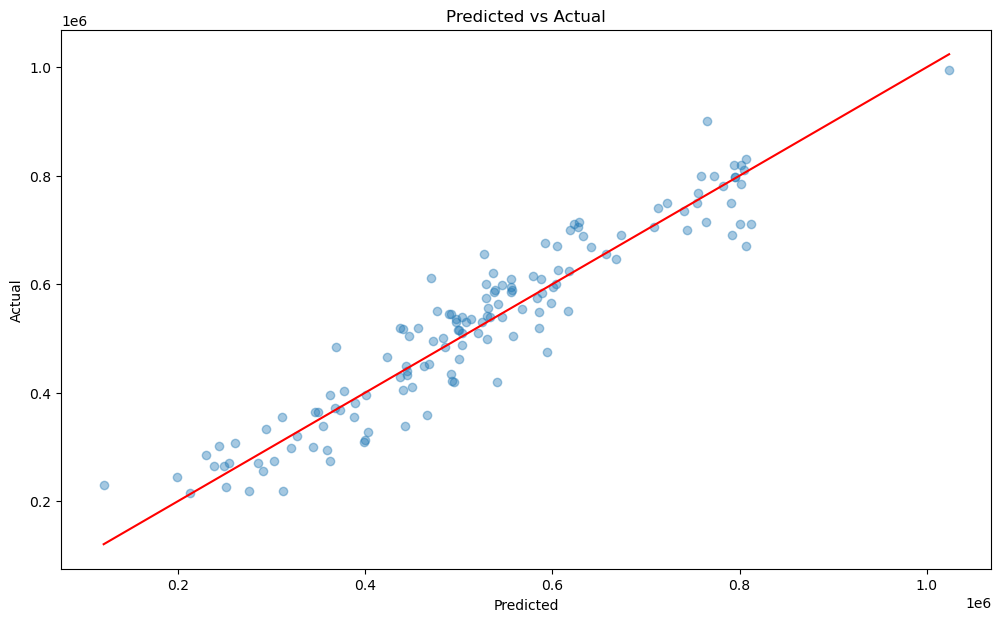

In [21]:
plot_prediction(y_test, y_pred)

In [22]:
svm_model = build_model(X_train, y_train, "svm")

svm_model.score(X_test, y_test)

0.7038349028710607

In [23]:
y_pred = svm_model.predict(X_test)

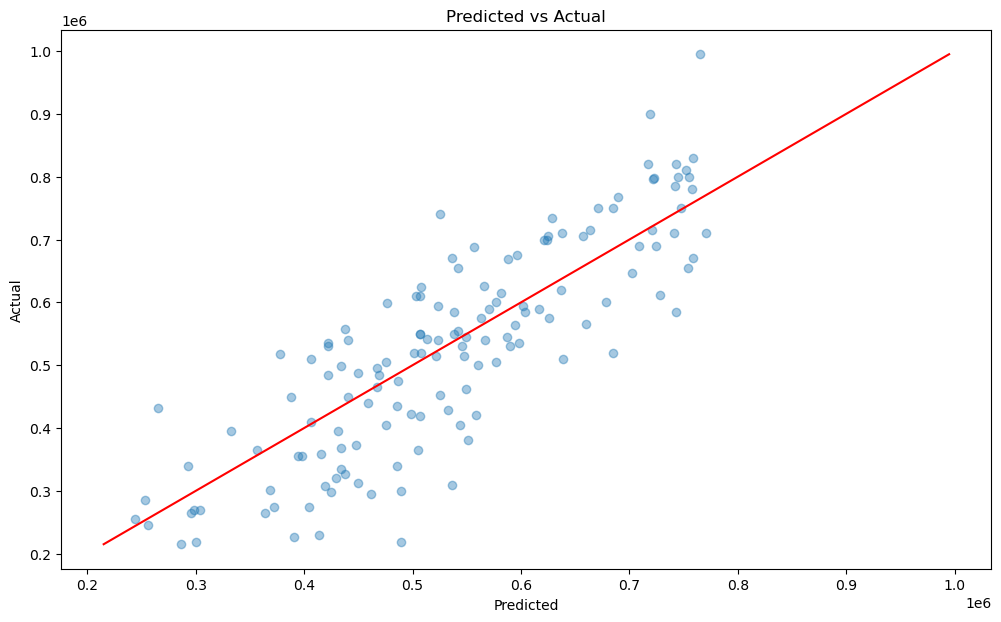

In [24]:
plot_prediction(y_test, y_pred)

In [25]:
randomforest_model = build_model(X_train, y_train, "randomforest")

randomforest_model.score(X_test, y_test)

0.879395482932122

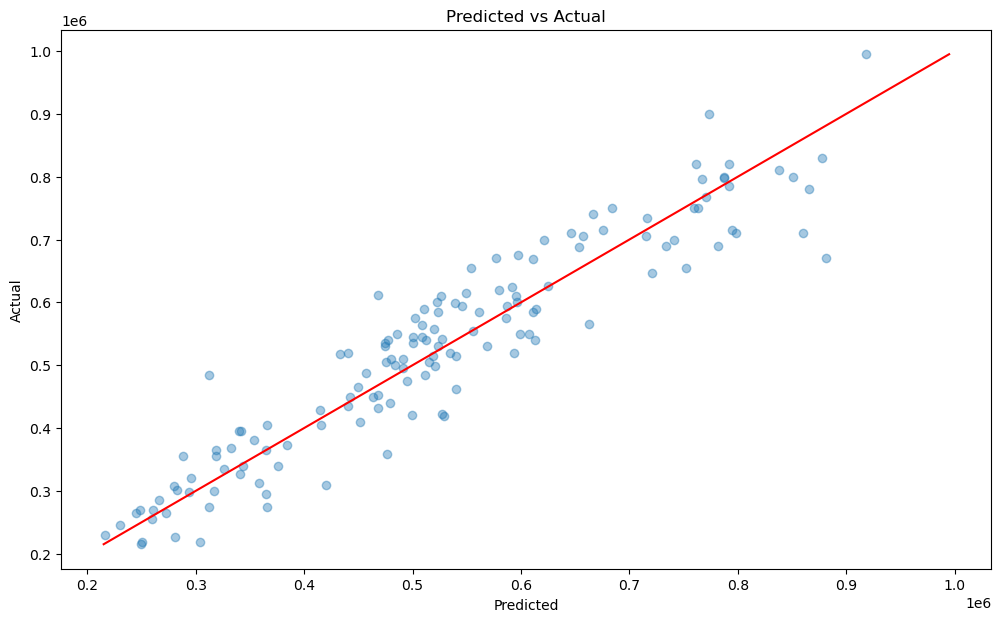

In [26]:
y_pred = randomforest_model.predict(X_test)
plot_prediction(y_test, y_pred)

In [27]:
spesificModels = df["Model"].unique()
spesificModels.sort()


In [28]:
selectedModel = widgets.Dropdown(
    options=spesificModels,
    description='Araç Model:',
    disabled=False,
)
selectedModel

Dropdown(description='Araç Model:', options=('1.0 EcoTSI Ecomotive Style', '1.0 EcoTSI Style Visio', '1.0 TSI …

In [30]:
spesificModelsDF = pd.DataFrame(columns=spesificModels)
spesificModelsDF.loc[0, selectedModel.value] = 1
spesificModelsDF.fillna(0, inplace=True)
spesificModelsDF

,1.0 EcoTSI Ecomotive Style,1.0 EcoTSI Style Visio,1.0 TSI Style,1.0 eTSI Style Plus,1.2 TSI Style,1.4 EcoTSI FR,1.4 EcoTSI Xcellence,1.4 TSI Copa Plus,1.4 TSI FR,1.4 TSI SC FR,...,1.6 TDI Style,1.6 TDI X-Perience,1.6 TDI Xcellence,1.9 TDI Signo,1.9 TDI Sport,1.9 TDI Style,2.0 TDI CR FR,2.0 TDI Stylance,2.0 TFSI Cupra,2.0 TSI Cupra
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
year = widgets.BoundedIntText(
    value=2022,
    min=1950,
    max=2022,
    step=1,
    description='Yıl:',
    disabled=False
)
year

BoundedIntText(value=2022, description='Yıl:', max=2022, min=1950)

In [32]:
km = widgets.IntSlider(
    value=0,
    min=0,
    max=1000000,
    step=1000,
    description='Kilometre:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
km

IntSlider(value=0, continuous_update=False, description='Kilometre:', max=1000000, step=1000)

In [33]:
print(linear_model.predict([[year.value, km.value, *spesificModelsDF.values[0]]]))

[818605.18002794]


/Applications/anaconda3/envs/390/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Interactive Playground

You can use the widgets below to make predictions.

In [34]:
ml_model = ["linear", "svm", "randomforest"]

@interact(ml_model = ml_model, year=year, km=km, model_name=selectedModel)
def predict_price(ml_model, year, km, model_name):
    print("Price prediction for {} - {}".format(chosenBrand.value, chosenModel.value))

    spesificModelsDF = pd.DataFrame(columns=spesificModels)
    spesificModelsDF.loc[0, model_name] = 1
    spesificModelsDF.fillna(0, inplace=True)
    if ml_model == "linear":
        price = linear_model.predict([[year, km, *spesificModelsDF.values[0]]])
        print("Predicted price: {} TL".format(price[0].round(2)))
    elif ml_model == "svm":
        price = svm_model.predict([[year, km, *spesificModelsDF.values[0]]])
        print("Predicted price: {} TL".format(price[0].round(2)))
    elif ml_model == "randomforest":
        price = randomforest_model.predict([[year, km, *spesificModelsDF.values[0]]])
        print("Predicted price: {} TL".format(price[0].round(2)))
    

interactive(children=(Dropdown(description='ml_model', options=('linear', 'svm', 'randomforest'), value='linea…